In [1]:
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm


import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('bandwidth.csv')


#the bandwidth usage started on the 1st of january of 2019
# namdwidth is measured in Mbps (megabits per second) which equals 106 bps

start_date = '2019-1-1'
end_date = pd.to_datetime(start_date) + pd.DateOffset(hours=len(df) - 1)
df['time'] = pd.date_range(start=start_date, end=end_date, freq='H')


# Set 'time' as the index
df.set_index('time', inplace=True)
print(df)

                     hourly_bandwidth
time                                 
2019-01-01 00:00:00       1000.496714
2019-01-01 01:00:00       1000.969408
2019-01-01 02:00:00       1002.046019
2019-01-01 03:00:00       1004.702118
2019-01-01 04:00:00       1007.447816
...                               ...
2020-02-21 11:00:00        740.546059
2020-02-21 12:00:00        738.906228
2020-02-21 13:00:00        736.057995
2020-02-21 14:00:00        733.559640
2020-02-21 15:00:00        732.190049

[10000 rows x 1 columns]


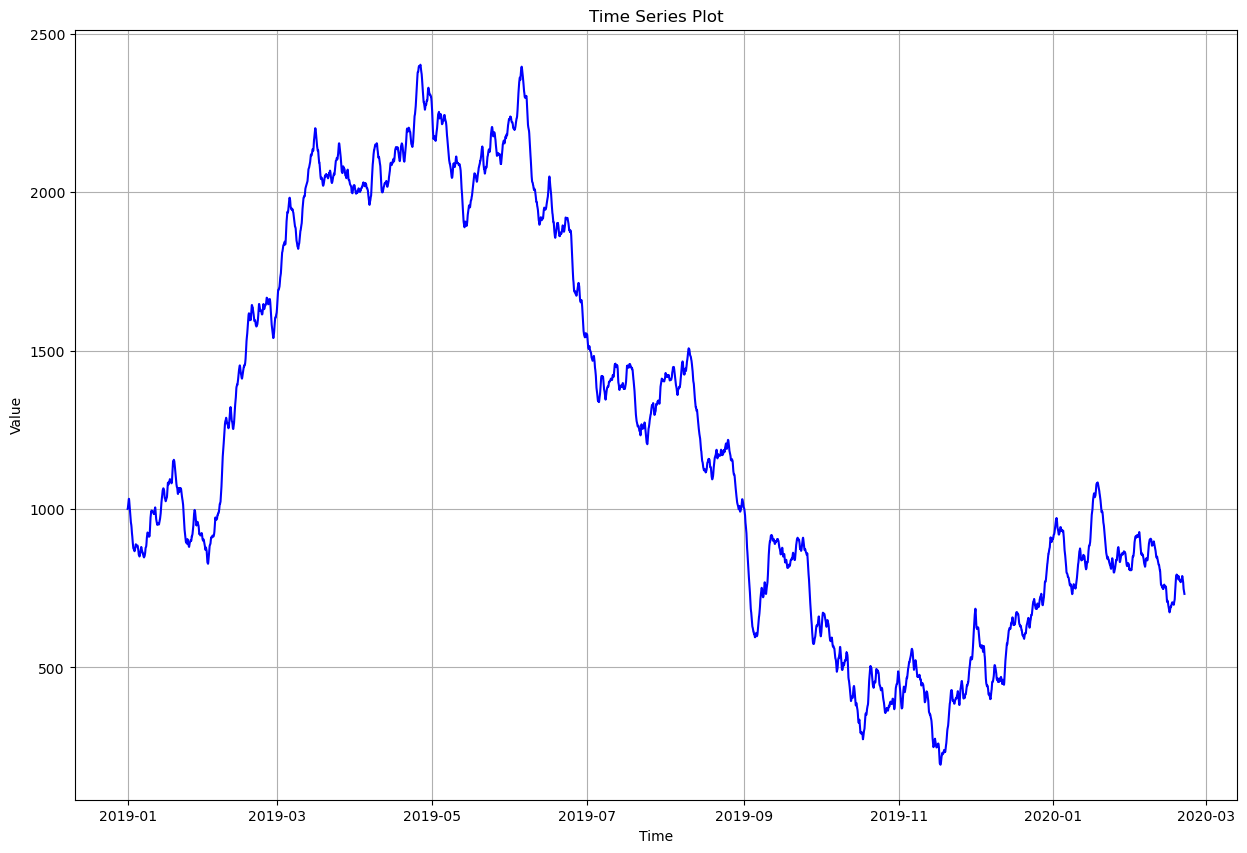

In [3]:
#ex2 - Visualize the time series.
#better to plot this time series

plt.figure(figsize=(15, 10))
plt.plot( df, linestyle='-', color='b')
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [4]:
#ex3
# let's use the acrf to verify wether the time series is stationary

ADF_result = adfuller(df)

print(f"ADF Statistic: {round(ADF_result[0], 3)}")
print(f"p-value: {round(ADF_result[1], 3)}")

if round(ADF_result[1], 3) < 0.05:
    print('Time Series is Stationary!')
else:
    print('Time Series is not Stationary!')

ADF Statistic: -0.871
p-value: 0.797
Time Series is not Stationary!


ADF Statistic: -20.695
p-value: 0.0
Time Series is Stationary!


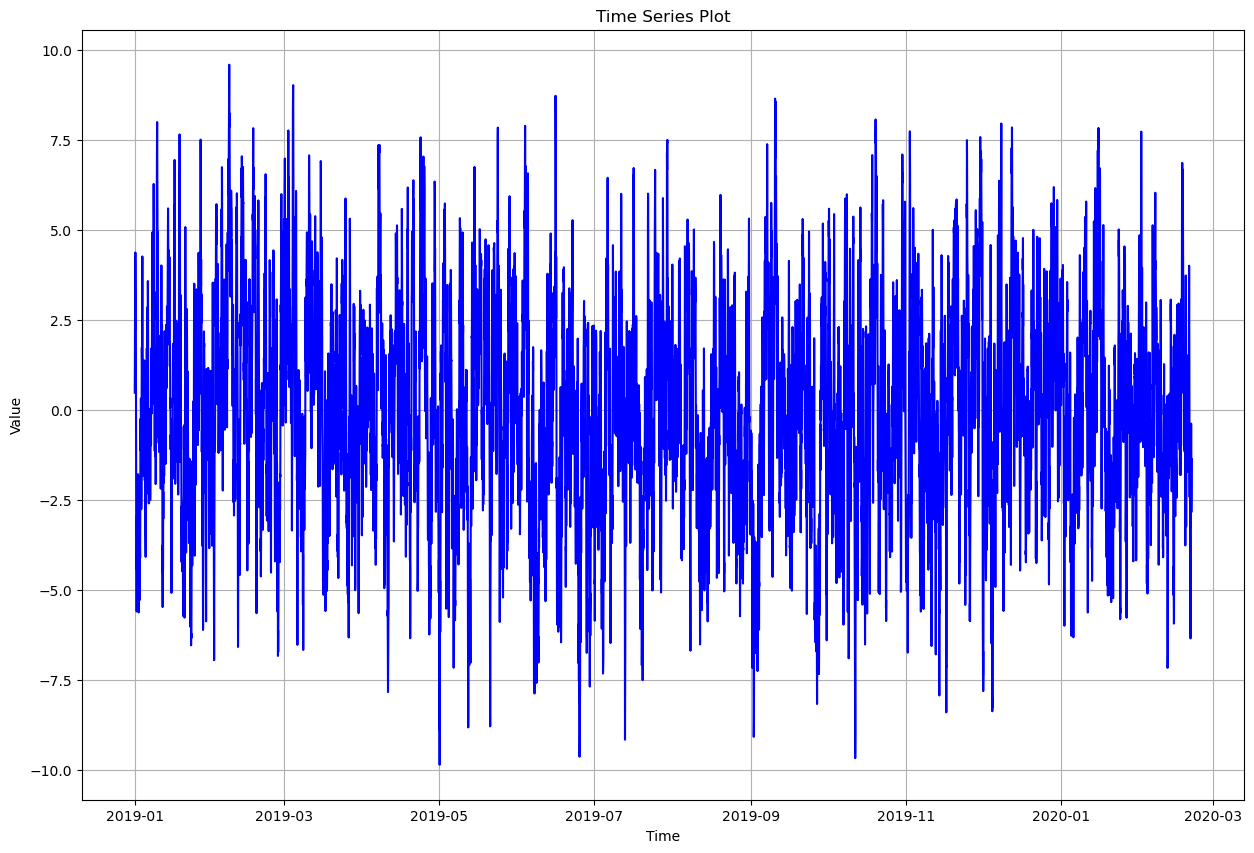

In [5]:
#ex4
# a. Apply the transformations to make the time series stationary

#let's apply differencing


df_diff = df.diff().iloc[1:]


ADF_result = adfuller(df_diff)

print(f"ADF Statistic: {round(ADF_result[0], 3)}")
print(f"p-value: {round(ADF_result[1], 3)}")

if round(ADF_result[1], 3) < 0.05:
    print('Time Series is Stationary!')
else:
    print('Time Series is not Stationary!')


plt.figure(figsize=(15, 10))
plt.plot( df_diff, linestyle='-', color='b')
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()


<Figure size 1200x400 with 0 Axes>

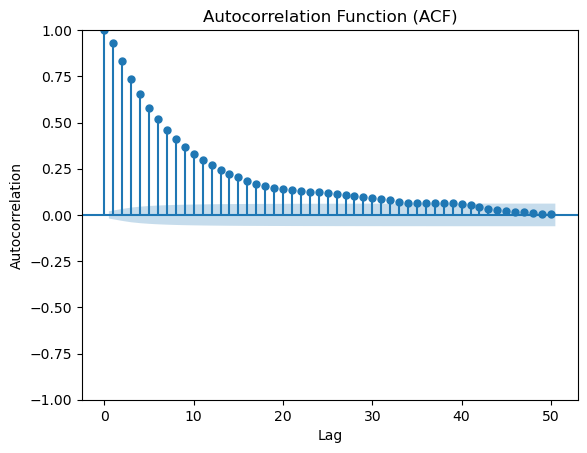

<Figure size 1200x400 with 0 Axes>

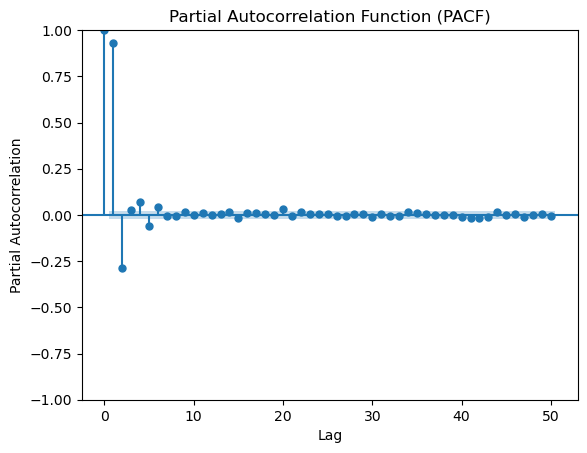

In [6]:
# b. Determine the adequate model to predict the series by plotting the autocorrelation and partial


# Plot ACF
plt.figure(figsize=(12, 4))
plot_acf(df_diff, lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 4))
plot_pacf(df_diff, lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [7]:
# autocorrelation functions
# c. Find the optimal (p , q) parameters.

def generate_order_list(x, y):
    # Generate all combinations of p and q within the specified range
    orders = list(itertools.product(range(x, y+1), repeat=2))

    # Filter out combinations where p and q are not distinct (optional)
    orders = [order for order in orders if order[0] != order[1]]

    return orders




def optimize_ARMA(data, order_list) -> pd.DataFrame:
    # print(data)
    results = []
    for order in order_list:
        try:
            model = SARIMAX(data, order=(order[0], 0, order[1]), simple_differencing=False, freq='H')

        except:
            continue

        aic = model.fit(disp=False, freq='H').aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


# print(optimize_ARMA(df_diff['hourly_bandwidth'], generate_order_list(1, 5)))



best_aic = optimize_ARMA(df_diff, generate_order_list(1, 5))

print(best_aic)

     (p,q)           AIC
0   (3, 2)  28451.239020
1   (2, 3)  28451.415534
2   (1, 5)  28452.019940
3   (4, 2)  28452.797770
4   (2, 4)  28453.233812
5   (5, 2)  28453.287846
6   (4, 3)  28453.413771
7   (5, 3)  28454.072570
8   (1, 4)  28454.142962
9   (2, 5)  28454.279537
10  (4, 5)  28454.385342
11  (3, 4)  28455.374598
12  (3, 5)  28455.666369
13  (5, 4)  28456.621550
14  (5, 1)  28458.903053
15  (1, 3)  28462.681589
16  (4, 1)  28463.453262
17  (1, 2)  28511.683945
18  (3, 1)  28534.528098
19  (2, 1)  28559.689002


In [8]:
# d. Fit the ARMA(p,q) model with the optimal parameters on the training set

p, q = best_aic['(p,q)'].iloc[0]


# Fit ARMA(p,q) model
model = sm.tsa.ARIMA(df_diff, order=(p, 0, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       hourly_bandwidth   No. Observations:                 9999
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -14219.595
Date:                Sat, 16 Dec 2023   AIC                          28453.189
Time:                        17:15:32   BIC                          28503.661
Sample:                    01-01-2019   HQIC                         28470.274
                         - 02-21-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0274      0.123     -0.223      0.823      -0.268       0.213
ar.L1          0.3583      0.053      6.782      0.000       0.255       0.462
ar.L2          0.4102      0.066      6.185      0.0

<Figure size 1200x400 with 0 Axes>

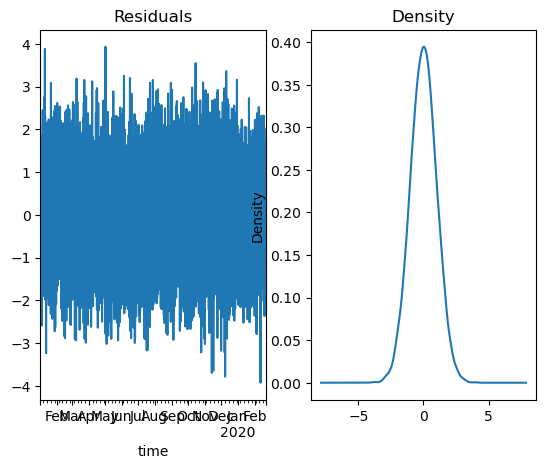

<Figure size 1200x400 with 0 Axes>

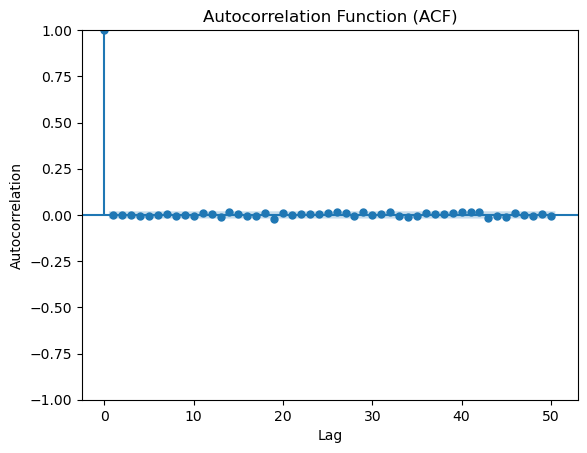

<Figure size 1200x400 with 0 Axes>

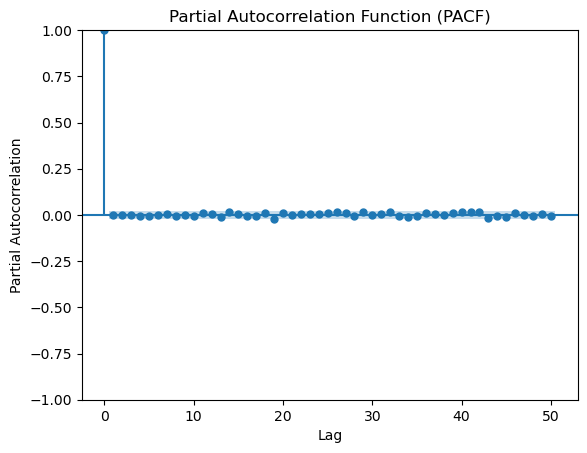

In [9]:
# e. Perform the residual analysis to validate if the model can be used to forecast.
residuals = model_fit.resid[1:]

residuals_test = acorr_ljungbox(residuals, np.arange(1, 11, 1))

residuals_test['lb_pvalue'].describe()


plt.figure(figsize=(12, 4))
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(title="Density", kind='kde', ax=ax[1])
plt.show


# Plot ACF
plt.figure(figsize=(12, 4))
plot_acf(residuals, lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 4))
plot_pacf(residuals, lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()



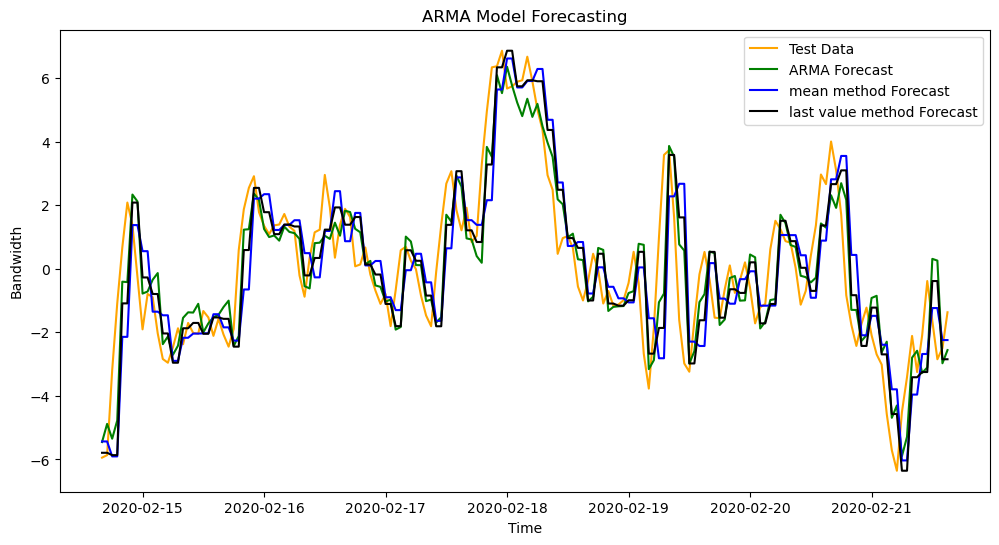

In [10]:
#ex5
df_train = df_diff.iloc[:-7*24]
df_test = df_diff.iloc[-(7*24):]

def rolling_forecast(function: str, df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:
    if (function.lower() == 'arma'):
        total_len = train_len + horizon
        pred_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(p,0,q))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA
    
    elif function.lower() == 'mean':
        pred_mean = []

        for i in range(train_len, len(df) + 1, window):
            mean_value = df[i - window:i].mean()  # Replace 'your_column_name' with the actual column name
            pred_mean.extend([mean_value] * window)

        return pred_mean[:168]  # Ensure only 168 predictions are returned

    elif function.lower() == 'last':
        pred_last = []

        for i in range(train_len, len(df) + 1, window):
            last_value = df[i - 1:i].iloc[-1]  # Replace 'your_column_name' with the actual column name
            pred_last.extend([last_value] * window)

        return pred_last[:168]  # Ensure only 168 predictions are returned

        

pred_MA = rolling_forecast('arma', df_diff, len(df_train), len(df_test), 2)
pred_mean = rolling_forecast('mean', df_diff, len(df_train), len(df_test), 2)
pred_last = rolling_forecast('last', df_diff, len(df_train), len(df_test), 2)


# Plot the training data, test data, and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df_test, label='Test Data', color='orange')
plt.plot(df_test.index, pred_MA, label='ARMA Forecast', color='green')
plt.plot(df_test.index, pred_mean, label='mean method Forecast', color='blue')
plt.plot(df_test.index, pred_last, label='last value method Forecast', color='black')

plt.title('ARMA Model Forecasting')
plt.xlabel('Time')
plt.ylabel('Bandwidth')
plt.legend()
plt.show()

In [11]:
#let's compare these 3 models according to their Mean Squared Error metric




# Calculate MSE for ARMA prediction
mse_arma = mean_squared_error(df_test, pred_MA)

# Calculate MSE for mean prediction
mse_mean = mean_squared_error(df_test, pred_mean)

# Calculate MSE for last prediction
mse_last = mean_squared_error(df_test, pred_last)

print("MSE for ARMA:", mse_arma)
print("MSE for mean:", mse_mean)
print("MSE for last:", mse_last)

MSE for ARMA: 1.7728168792754526
MSE for mean: 2.8945474427571165
MSE for last: 2.2297582947733656


723.1209335578892


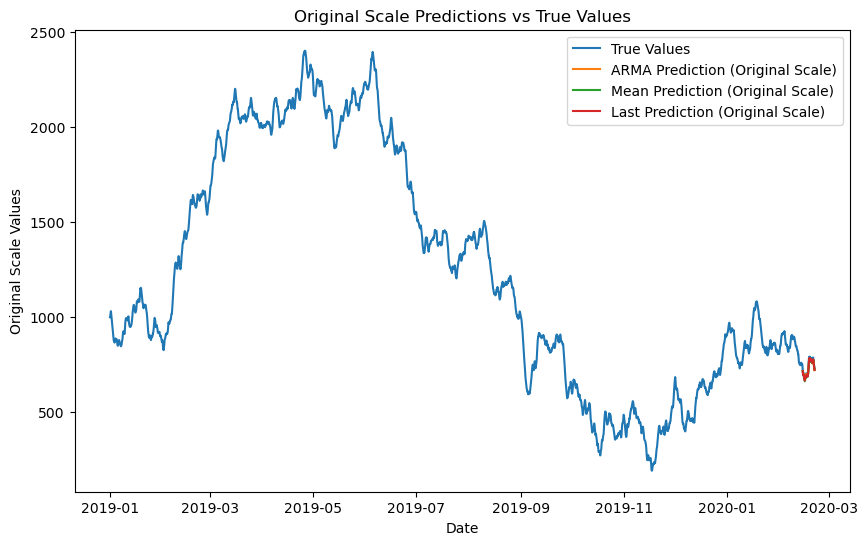

In [38]:
#reverse to original scale with cumsum

initial_value = df['hourly_bandwidth'].iloc[-169]
print(initial_value)

# Reverse differencing and bring values to the original scale
pred_MA_original_scale = df['hourly_bandwidth'].iloc[-169] + np.cumsum(pred_MA)
pred_mean_original_scale = df['hourly_bandwidth'].iloc[-169] + np.cumsum(pred_mean)
pred_last_original_scale = df['hourly_bandwidth'].iloc[-169] + np.cumsum(pred_last)


# Plot the original scale predictions and the true values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['hourly_bandwidth'], label='True Values')
plt.plot(df_test.index, pred_MA_original_scale, label='ARMA Prediction (Original Scale)')
plt.plot(df_test.index, pred_mean_original_scale, label='Mean Prediction (Original Scale)')
plt.plot(df_test.index, pred_last_original_scale, label='Last Prediction (Original Scale)')

plt.title('Original Scale Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Original Scale Values')
plt.legend()
plt.show()



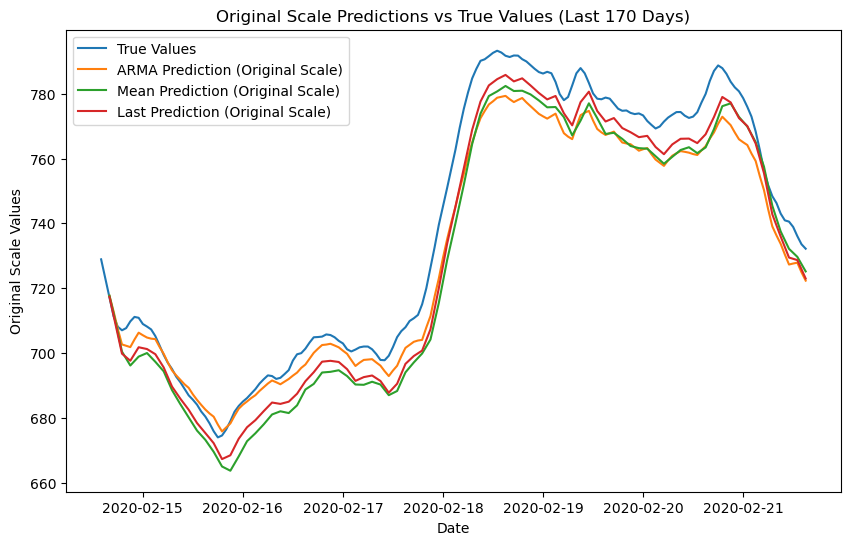

In [39]:
# Plot the original scale predictions and the true values for the last 170 days
plt.figure(figsize=(10, 6))
plt.plot(df.index[-170:], df['hourly_bandwidth'].iloc[-170:], label='True Values')
plt.plot(df_test.index[-170:], pred_MA_original_scale[-170:], label='ARMA Prediction (Original Scale)')
plt.plot(df_test.index[-170:], pred_mean_original_scale[-170:], label='Mean Prediction (Original Scale)')
plt.plot(df_test.index[-170:], pred_last_original_scale[-170:], label='Last Prediction (Original Scale)')

plt.title('Original Scale Predictions vs True Values (Last 170 Days)')
plt.xlabel('Date')
plt.ylabel('Original Scale Values')
plt.legend()
plt.show()